# Librerias

In [1]:
import pandas as pd
import numpy as np
import pyreadstat
import xlwings as xlw
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys
from os import listdir
from sklearn.neighbors import KernelDensity
from IPython.display import clear_output
import cufflinks as cf
from unidecode import unidecode
import ipystata
from linearmodels.panel import PanelOLS
from tqdm.notebook import tqdm
from tqdm import tqdm_gui

sns.set()
# sns.set_style("darkgrid")
%matplotlib inline
cf.go_offline()

# Definiciones

In [2]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if str(value).lower() in [ s.lower() for s in lst2] ] 
    return lst3

def read_meta(file):
    df, meta = pyreadstat.read_sav(file+'.sav', metadataonly=True)
    return meta

def read_columns(file):
    df, meta = pyreadstat.read_sav(file+'.sav', metadataonly=True)
    columns = [s.lower() for s in df.columns]
    return columns

def weight_array(ar, weights):
    zipped = zip(ar, weights)
    weighted = []
    for i in zipped:
        for j in range(i[1]):
            weighted.append(i[0])
    return np.array(weighted)

def weighted_qcut(values, weights, q, **kwargs):
    'Return weighted quantile cuts from a given series, values.'
    if type(q)==int:
        quantiles = np.linspace(0, 1, q + 1)
    else:
        quantiles = q
    order = weights.iloc[values.argsort()].cumsum()
    bins = pd.cut(order / order.iloc[-1], quantiles, labels=False, **kwargs)
    return bins.sort_index()

def weighted_percentile(data, percents, weights=None):
    if weights is None:
        return np.percentile(data, percents)
    ind=np.argsort(data)
    d=data.iloc[ind]
    w=weights.iloc[ind]
    p=1.*w.cumsum()/w.sum()*100
    y=np.interp(percents, p, d)
    return y

def weighted_percentileofscore(values, weights=None, values_sorted=False):
    """ Similar to scipy.percentileofscore, but supports weights.
    :param values: array-like with data.
    :param weights: array-like of the same length as `values`.
    :param values_sorted: bool, if True, then will avoid sorting of initial array.
    :return: numpy.array with percentiles of sorted array.
    """
    values = np.array(values)
    if weights is None:
        weights = np.ones(len(values))
    weights = np.array(weights)

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        weights = weights[sorter]

    total_weight = weights.sum()
    return 100 * np.cumsum(weights) / total_weight

def read_sav(file,cambios1,cambios2):
    'Lee el archivo .sav y devuelve un dataframe' 
    print(file[0:4],end='|')
    df, meta = pyreadstat.read_sav(file+'.sav', metadataonly=False)
    
    # Selecciona solo columnas relevantes:
    df = df[intersection(df.columns, variables_relevantes)]
    
    # Crea columnas con descripción de las variables
    labels = meta.variable_value_labels
    for var in intersection(df.columns, labels.keys()):
        df[var+'_desc'] = df[var].map(labels[var]).fillna(df[var])
    # Lowercase columns
    df.columns = [ str(s).lower() for s in df.columns ]

    df.rename(columns = cambios1 ,inplace=True)
    df.rename(columns =  cambios2,inplace=True)
    return df

In [3]:
df_t, meta_t = pyreadstat.read_sav('201612'+'.sav', metadataonly=True)
provincias = meta_t.variable_value_labels['prov']
lista_amazonia = ['Morona Santiago','Napo','Pastaza','Zamora Chinchipe','Sucumbíos','Orellana']
for k in provincias:
    if provincias[k] in lista_amazonia:
        provincias[k] = 'Amazonía'

provincias[24]='Guayas'
provincias[23]='Pichincha'

print(provincias)

{1.0: 'Azuay', 2.0: 'Bolívar', 3.0: 'Cañar', 4.0: 'Carchi', 5.0: 'Cotopaxi', 6.0: 'Chimborazo', 7.0: 'El Oro', 8.0: 'Esmeraldas', 9.0: 'Guayas', 10.0: 'Imbabura', 11.0: 'Loja', 12.0: 'Los Ríos', 13.0: 'Manabí', 14.0: 'Amazonía', 15.0: 'Amazonía', 16.0: 'Amazonía', 17.0: 'Pichincha', 18.0: 'Tungurahua', 19.0: 'Amazonía', 20.0: 'Galapagos', 21.0: 'Amazonía', 22.0: 'Amazonía', 23.0: 'Pichincha', 24.0: 'Guayas', 90.0: 'Zonas no Delimitadas'}


# Datos

## Importacion

In [4]:
#---------------------------------- Variables relevantes ----------------------------------
variables_relevantes = ['hogar','numpers','formul','vivienda','persona','ciudad','id_hogar','secemp','fexp','sexo','p02','edad','p03','nivinst','p10a','area','rama1','grupo1',
                        'p44f','p05a','p05b','p15','p40','p41','p42','p43',
                        'empleo','epobreza','desempleo','desem','pea','pean','secemp','condact','condactn',
                        'ref','ingpc','ingrl']

variables_relevantes = [
    'vivienda','ciudad','sector','zona','panelm','hogar','id_hogar','id_persona','numpers','persona',  # Identificacion del hogar
    'fexp','sexo','p02','edad','p03','nivinst','p10a', # Caracteristicas del individuo
    'condact', 'secemp', # Variables Condicion del trabajo
    'ingpat','ingasg','ingepv','ingdom','ingjub','ingalq','ingotr','ingrl','p66','p67','ingpc','ingrl', # Variables de ingreso
                       ]
#---------------------------------- Years ----------------------------------
lista_archivos = [s.replace('.sav', '') for s in listdir() if '.sav' in s]
lista_archivos.sort(reverse=True)

#---------------------------------- Cambios columnas -----------------------
cambios1 = {'edad':'p03' ,'sexo':'p02','nivinst':'p10a'}
cambios2 = { i+'_desc':v+'_desc' for (i,v) in cambios1.items()}

#---------------------------------- Otros ----------------------------------
df_data = pd.read_excel('data.xlsx','data',3).set_index('year')
df_data.index = df_data.index.astype(str)+'12'

In [5]:
if False:    
    df_dict = {file:read_sav(file, cambios1, cambios2) for file in tqdm(lista_archivos)}
    meta_dict = {file:read_meta(file) for file in lista_archivos}
    df = pd.concat(df_dict.values(),keys=df_dict.keys(),sort=False).reset_index().rename(columns={"level_0":"year"})
    del df_dict
    df.to_pickle('df_enemdu2')
else:
    df = pd.read_pickle('df_enemdu2')
    meta_dict = {file:read_meta(file) for file in lista_archivos}
clear_output(wait=True)

In [6]:
df[df.ingrl == 999999]

,year,level_1,ciudad,zona,sector,vivienda,hogar,persona,numpers,p03,...,p10a_desc,condact_desc,panelm,panelm_desc,ingpc,id_hogar,id_persona,ingrl_desc,vivienda_desc,hogar_desc
659663,200712,175,010150,004,004,03,1,NaN,NaN,20.0,...,Secundaria,Desempleo abierto,210,NaN,100.000000,010150004004210031,01015000400421003103,No informa,NaN,NaN
659675,200712,187,010150,004,004,03,1,NaN,NaN,37.0,...,Ninguno,Desempleo abierto,220,NaN,60.000000,010150004004220031,01015000400422003102,No informa,NaN,NaN
659687,200712,199,010150,005,001,03,1,NaN,NaN,65.0,...,Primaria,Empleo no clasificado,190,NaN,NaN,010150005001190031,01015000500119003102,No informa,NaN,NaN
659796,200712,308,010150,005,008,01,1,NaN,NaN,40.0,...,Post-grado,Empleo no clasificado,200,NaN,62.500000,010150005008200011,01015000500820001103,No informa,NaN,NaN
659871,200712,383,010150,006,001,01,1,NaN,NaN,16.0,...,Educación Básica,Desempleo oculto,220,NaN,70.000000,010150006001220011,01015000600122001102,No informa,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1770914,201912,56340,230150,NaN,NaN,08,1,NaN,NaN,56.0,...,Secundaria,Empleo no clasificado,006,006,33.333333,230150014903006081,23015001490300608101,No informa,08,Hogar Uno
1772174,201912,57600,240150,NaN,NaN,03,1,NaN,NaN,30.0,...,Secundaria,Empleo no clasificado,099,099,164.000000,240150006004099031,24015000600409903101,No informa,03,Hogar Uno
1772913,201912,58339,240250,NaN,NaN,04,1,NaN,NaN,32.0,...,Superior Universitario,Empleo no clasificado,099,099,NaN,240250005901099041,24025000590109904101,No informa,04,Hogar Uno
1773122,201912,58548,240350,NaN,NaN,07,1,NaN,NaN,51.0,...,Primaria,Empleo no clasificado,012,012,NaN,240350003302012071,24035000330201207101,No informa,07,Hogar Uno


## Limpieza

In [7]:
df_data = pd.read_excel('data.xlsx','data',3)
df_data['year'] = df_data.year.astype(str)+'12'
df_data.set_index('year', inplace=True)

# df.hogar.value_counts(dropna=False)
df['id_hogar'] = np.where(df.id_hogar.isna(),
                          df.ciudad.astype(str)+df.zona.astype(str)+df.sector.astype(str)+df.panelm.astype(str)+df.vivienda.astype(str)+df.hogar.astype(str),
                          df.id_hogar).astype(str)
df['v1'] = 1
df['ingrl'] = np.where(df.ingrl < 0, 0 ,df.ingrl)
df['ingrl'] = np.where(df.ingrl == 999999, np.nan ,df.ingrl)

condact_desc_map = {'OCUPDADOS INDETERMINADOS':'Empleo no clasificado','Ocupados no bien definidos':'Empleo no clasificado','Ocupados no bién definidos':'Empleo no clasificado',
               'OCUPADOS PLENOS':'Empleo Adecuado/Pleno','Ocupados plenos':'Empleo Adecuado/Pleno','SUBEMPLEADOS INVISIBLE':'Subempleo por insuficiencia de tiempo de trabajo',
               'Subempleo invisible':'Subempleo por insuficiencia de tiempo de trabajo','Subocupados invisibles':'Subempleo por insuficiencia de tiempo de trabajo',
               'SUBEMPLEADOS VISIBLE':'Subempleo por insuficiencia de ingresos','Subempleo visible':'Subempleo por insuficiencia de ingresos',
               'Subocupados visibles':'Subempleo por insuficiencia de ingresos','Informales':'Otro empleo no pleno','SUBEMPLEADOS INFORMALES':'Otro empleo no pleno',
               'Subempleo informal':'Otro empleo no pleno','DESOCUPADOS CESANTES':'Desempleo oculto','Desocupados cesantes':'Desempleo oculto',
               'DESOCUPADOS 1A VEZ':'Desempleo abierto','Desocupados 1era vez':'Desempleo abierto','Desocupados primera vez':'Desempleo abierto',
               'INACTIVOS':'Población Económicamente Inactiva','Inactivos':'Población Económicamente Inactiva','MENORES DE EDAD':'Menores de 15 años',
               'Menores de 10 años':'Menores de 15 años','Menores de edad':'Menores de 15 años','INDETERMINADOS':'Población Económicamente Inactiva',
               'Otros inactivos':'Población Económicamente Inactiva'}

df.replace({'condact_desc':condact_desc_map}, inplace=True)

condact_map = {'Menores de 15 años':'0',
               'Empleo Adecuado/Pleno':'1',
               'Subempleo por insuficiencia de tiempo de trabajo':'2',
               'Subempleo por insuficiencia de ingresos':'3',
               'Otro empleo no pleno':'4',
               'Empleo no remunerado':'5',
               'Empleo no clasificado':'6',
               'Desempleo abierto':'7',
               'Desempleo oculto':'8',
               'Población Económicamente Inactiva':'9'}

df['condact'] = df.replace({'condact_desc':condact_map})['condact_desc'].astype(int)
df['pea'] = np.where(df.condact.between(1,8),1,0)
df['desempleo'] = np.where(df.condact.between(7,8),1,0)
df['desempleo2'] = df.desempleo+df.pea

df['npersonas'] = df.groupby(['year','id_hogar'])['v1'].transform('sum')
df['ingsum'] = df.groupby(['year','id_hogar'])['ingrl'].transform('sum')
df['ingpc2'] = df.ingsum / df.npersonas
df['ingpc'] = np.where(df.ingpc,df.ingpc2,df.ingpc)

df['ciudad'] = df['ciudad'].astype('int')
df['provincia'] = df['ciudad'].astype('str').str[:-4].astype('int').map(provincias)

df = df.merge(df_data, how='left', left_on='year', right_index=True)
df['laggedyear'] = (df.year.astype(int).add(-100).astype(str))
df = df.merge(df_data[['sbu','sbu_r', 'sbu_ppp']], how='left', left_on='laggedyear', right_index=True, suffixes=('','_lag'))

df['p_provincial'] = df.groupby(['year','provincia']).apply(lambda x: weighted_qcut(x.ingpc,x.fexp,10)).reset_index([0,1],drop=True)
df['p_nacional'] = df.groupby(['year']).apply(lambda x: weighted_qcut(x.ingpc,x.fexp,10)).reset_index(0,drop=True)

# df['filtro'] = df.groupby(['year'])['ingrl'].transform(np.percentile)
# .apply(lambda x: np.percentile(x.ingrl,[1,99])).reset_index(0,drop=True)

for var in ['ingrl','ingpc']:
    df[var+'_r'] = df[var] / df['tcambio'] / df['ipc']
#     df[var+'_r'] = np.divide(df[var],df['tcambio'] * df['ipc']) * 100
#     df[var+'_ppp'] = df[var]/df['ppp_factor']
    df['fa_'+var] = np.where((df[var] >= df.sbu*0.9) & (df[var] <= df.sbu*1.1),'fa_'+var,'nfa_'+var)
    df['fb_'+var] = np.where(df[var] < df.sbu*0.9,'fb_'+var,'nfb_'+var)
    df['faf_'+var] = np.where((df[var] >= df.sbu_lag) & (df[var] <= df.sbu),'faf_'+var,'nfaf_'+var)


df.columns

Index(['year', 'level_1', 'ciudad', 'zona', 'sector', 'vivienda', 'hogar',
       'persona', 'numpers', 'p03', 'p02', 'p10a', 'condact', 'ingrl', 'fexp',
       'p03_desc', 'p02_desc', 'p10a_desc', 'condact_desc', 'panelm',
       'panelm_desc', 'ingpc', 'id_hogar', 'id_persona', 'ingrl_desc',
       'vivienda_desc', 'hogar_desc', 'v1', 'pea', 'desempleo', 'desempleo2',
       'npersonas', 'ingsum', 'ingpc2', 'provincia', 'ppp_factor', 'ipc',
       'tcambio', 'sbu', 'sbu_r', 'sbu_ppp', 'laggedyear', 'sbu_lag',
       'sbu_r_lag', 'sbu_ppp_lag', 'p_provincial', 'p_nacional', 'ingrl_r',
       'fa_ingrl', 'fb_ingrl', 'faf_ingrl', 'ingpc_r', 'fa_ingpc', 'fb_ingpc',
       'faf_ingpc'],
      dtype='object')

# Panel

# Modelos

# Graficos

### Densidades

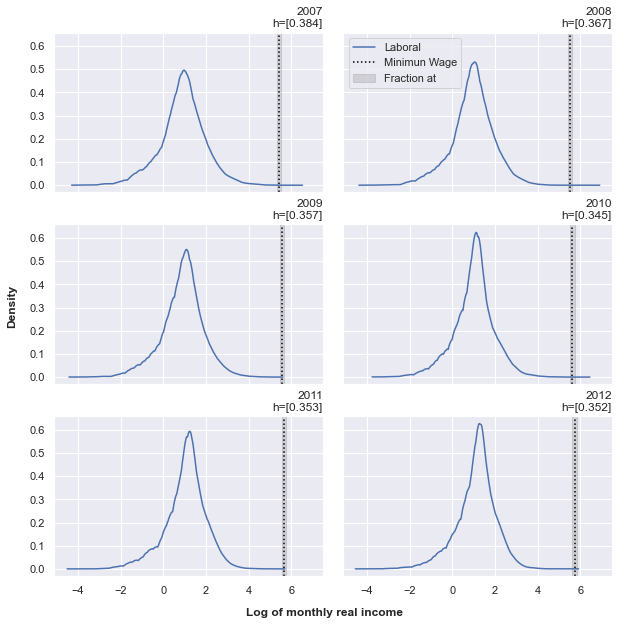

Wall time: 15.6 s


In [37]:
%%time
years = [str(i) for i in list(range(200712,201312,100))]
cols = 2

fig, axs = plt.subplots(int(len(years)/cols),cols,sharey=True,sharex=True,figsize=(10,10), gridspec_kw={'wspace':.075})

colors = ['red','blue','green','navy','orange']
# fig.suptitle('Densidades de ingresos laborales, cuenta propia y salarios')

for i,year in enumerate(years):
    P = 1000
    hl = list()
    variables = {
#                  'ingrsal_r':'Formal income',
#                  'ingrcp_r':'Informal income',
                 'ingrl_r':'Laboral',
#                  'ingpc_r':'PerCapita'
                }
    for var in variables.keys():
        cond = (df[var]>0) & (df['year']==year)
        df_t = df[cond][[var,'fexp']]
        X = np.log(np.array(df_t.iloc[:,0]).reshape(-1, 1))
        S = df_t.iloc[:,1]
        h = X.std()*(4/3/X.size)**(1/10) # Silverman rule of thumb for kernel bandwith
        hl.append(np.round(h,3))
        kde = KernelDensity(bandwidth=h,kernel='epanechnikov').fit(X=X, sample_weight=S)
        x_plot = np.linspace(X.min(), X.max(), P).reshape(-1,1)
        y_plot = np.exp(kde.score_samples(x_plot))
        y_plot_c = np.cumsum(y_plot)/np.cumsum(y_plot)[-1]
        axi = int((i-i%cols)/cols)
        axj = i%2        
        axs[axi,axj].plot(x_plot,y_plot,label=variables[var])
#         axs[1,i].plot(x_plot,y_plot_c,label=variables[var])
        print(year, variables[var])
        clear_output(wait=True)
        
    axs[axi,axj].axvspan(np.log(df_data.sbu_r[year]*0.90),np.log(df_data.sbu_r[year]*1.10), alpha=0.25, color='grey', label='Fraction at')
    axs[axi,axj].axvline(np.log(df_data.sbu_r[year]), label='Minimun Wage', ls=':', color='black')

    axs[axi,axj].set_title(year[0:4]+'\n'+'h='+str(hl),loc='right') #,fontdict = {'fontsize' : 9})
    
fig.text(0.5, 0.07, 'Log of monthly real income', ha='center', fontdict = {'fontsize' : 12,'weight': 'bold'})
fig.text(0.06, 0.5, 'Density', va='center', rotation='vertical', fontdict = {'fontsize' : 12,'weight': 'bold'})
axs[0,1].legend(loc = 'upper left')

# fig.set_xlabel('common xlabel')
# fig.set_ylabel('common ylabel')
# fig.text(0.5, 0.04, 'common xlabel', ha='center', va='center')
# fig.text(0.06, 0.5, 'common ylabel', ha='center', va='center', rotation='vertical')

# plt.xlim((1,8))
plt.savefig('densidades1.png',dpi=300,bbox_inches='tight')
plt.show()

# Otros